In [69]:
from segysak.segy import segy_header_scan, segy_loader, well_known_byte_locs
import matplotlib.pyplot as plt
import xarray as xr
import skfuzzy as fuzz
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import uniform_filter, generic_filter


### Import danych

In [70]:
scan = segy_header_scan("TNE01_Full")

Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]


### Sprawdzanie paramterów

In [71]:
scan[scan["mean"] > 0]

byte_loc   count          mean           std  \
TRACE_SEQUENCE_LINE             1  1000.0  5.005000e+02    288.819436   
TRACE_SEQUENCE_FILE             5  1000.0  3.620000e+02      0.000000   
FieldRecord                     9  1000.0  3.620000e+02      0.000000   
TraceNumber                    13  1000.0  5.005000e+02    288.819436   
CDP                            21  1000.0  1.907000e+03    577.638872   
CDP_TRACE                      25  1000.0  1.000000e+00      0.000000   
TraceIdentificationCode        29  1000.0  1.000000e+00      0.000000   
DataUse                        35  1000.0  1.000000e+00      0.000000   
ElevationScalar                69  1000.0  1.000000e+00      0.000000   
SourceX                        73  1000.0  5.570523e+06  36537.740701   
SourceY                        77  1000.0  6.749913e+07  62278.028634   
CoordinateUnits                89  1000.0  1.000000e+00      0.000000   
TRACE_SAMPLE_COUNT            115  1000.0  1.001000e+03      0.000000   
TRACE_SAMPLE_INTERVAL         117  1000.0  4.000000e+03      0.000000   
Correlated                    125  1000.0  1.000000e+00      0.000000   
SweepType                     133  1000.0  1.000000e+00      0.000000   
TaperType                     139  1000.0  1.000000e+00      0.000000   
TimeBaseCode                  167  1000.0  1.000000e+00      0.000000   
CDP_X                         181  1000.0  5.570523e+06  36537.740701   
CDP_Y                         185  1000.0  6.749913e+07  62278.028634   
INLINE_3D                     189  1000.0  3.620000e+02      0.000000   
CROSSLINE_3D                  193  1000.0  1.907000e+03    577.638872   

                                min          25%         50%          75%  \
TRACE_SEQUENCE_LINE             1.0       250.75       500.5       750.25   
TRACE_SEQUENCE_FILE           362.0       362.00       362.0       362.00   
FieldRecord                   362.0       362.00       362.0       362.00   
TraceNumber                     1.0       250.75       500.5       750.25   
CDP                           908.0      1407.50      1907.0      2406.50   
CDP_TRACE                       1.0         1.00         1.0         1.00   
TraceIdentificationCode         1.0         1.00         1.0         1.00   
DataUse                         1.0         1.00         1.0         1.00   
ElevationScalar                 1.0         1.00         1.0         1.00   
SourceX                   5507333.0   5538928.25   5570523.5   5602118.50   
SourceY                  67391426.0  67445279.25  67499133.0  67552986.00   
CoordinateUnits                 1.0         1.00         1.0         1.00   
TRACE_SAMPLE_COUNT           1001.0      1001.00      1001.0      1001.00   
TRACE_SAMPLE_INTERVAL        4000.0      4000.00      4000.0      4000.00   
Correlated                      1.0         1.00         1.0         1.00   
SweepType                       1.0         1.00         1.0         1.00   
TaperType                       1.0         1.00         1.0         1.00   
TimeBaseCode                    1.0         1.00         1.0         1.00   
CDP_X                     5507333.0   5538928.25   5570523.5   5602118.50   
CDP_Y                    67391426.0  67445279.25  67499133.0  67552986.00   
INLINE_3D                     362.0       362.00       362.0       362.00   
CROSSLINE_3D                  908.0      1407.50      1907.0      2406.50   

                                max  
TRACE_SEQUENCE_LINE          1000.0  
TRACE_SEQUENCE_FILE           362.0  
FieldRecord                   362.0  
TraceNumber                  1000.0  
CDP                          2906.0  
CDP_TRACE                       1.0  
TraceIdentificationCode         1.0  
DataUse                         1.0  
ElevationScalar                 1.0  
SourceX                   5633714.0  
SourceY                  67606840.0  
CoordinateUnits                 1.0  
TRACE_SAMPLE_COUNT           1001.0  
TRACE_SAMPLE_INTERVAL        4000.0  
Cor

In [72]:
V3D = xr.open_dataset(
    'TNE01_Full',
    engine="sgy_engine", 
    dim_byte_fields={"iline": 189, "xline": 193},
    extra_byte_fields={"cdp_x": 181, "cdp_y": 185}
)

Processing Chunks:   0%|          | 0.00/9.00 [00:00<?, ? trace-chunks/s]
Processing Chunks:  11%|█         | 1.00/9.00 [00:07<01:00, 7.61s/ trace-chunks]
Processing Chunks:  22%|██▏       | 2.00/9.00 [00:16<00:57, 8.15s/ trace-chunks]
Processing Chunks:  33%|███▎      | 3.00/9.00 [00:27<00:58, 9.67s/ trace-chunks]
Processing Chunks:  44%|████▍     | 4.00/9.00 [00:37<00:49, 9.94s/ trace-chunks]
Processing Chunks:  56%|█████▌    | 5.00/9.00 [00:53<00:47, 11.9s/ trace-chunks]
Processing Chunks:  67%|██████▋   | 6.00/9.00 [01:09<00:39, 13.3s/ trace-chunks]
Processing Chunks:  78%|███████▊  | 7.00/9.00 [01:24<00:27, 13.8s/ trace-chunks]
Processing Chunks:  89%|████████▉ | 8.00/9.00 [01:42<00:15, 15.3s/ trace-chunks]


In [73]:
V3D

<xarray.Dataset> Size: 4GB
Dimensions:  (iline: 590, xline: 1487, samples: 1001)
Coordinates:
  * iline    (iline) int16 1kB 362 364 366 368 370 ... 1532 1534 1536 1538 1540
  * xline    (xline) int16 3kB 908 910 912 914 916 ... 3872 3874 3876 3878 3880
  * samples  (samples) float32 4kB -2.0 2.0 6.0 ... 3.99e+03 3.994e+03 3.998e+03
Data variables:
    cdp_x    (iline, xline) int32 4MB ...
    cdp_y    (iline, xline) int32 4MB ...
    data     (iline, xline, samples) float32 4GB ...
Attributes:
    seisnc:   {"coord_scalar": -10.0, "coord_scaled": false}

### Wizualizacja danych

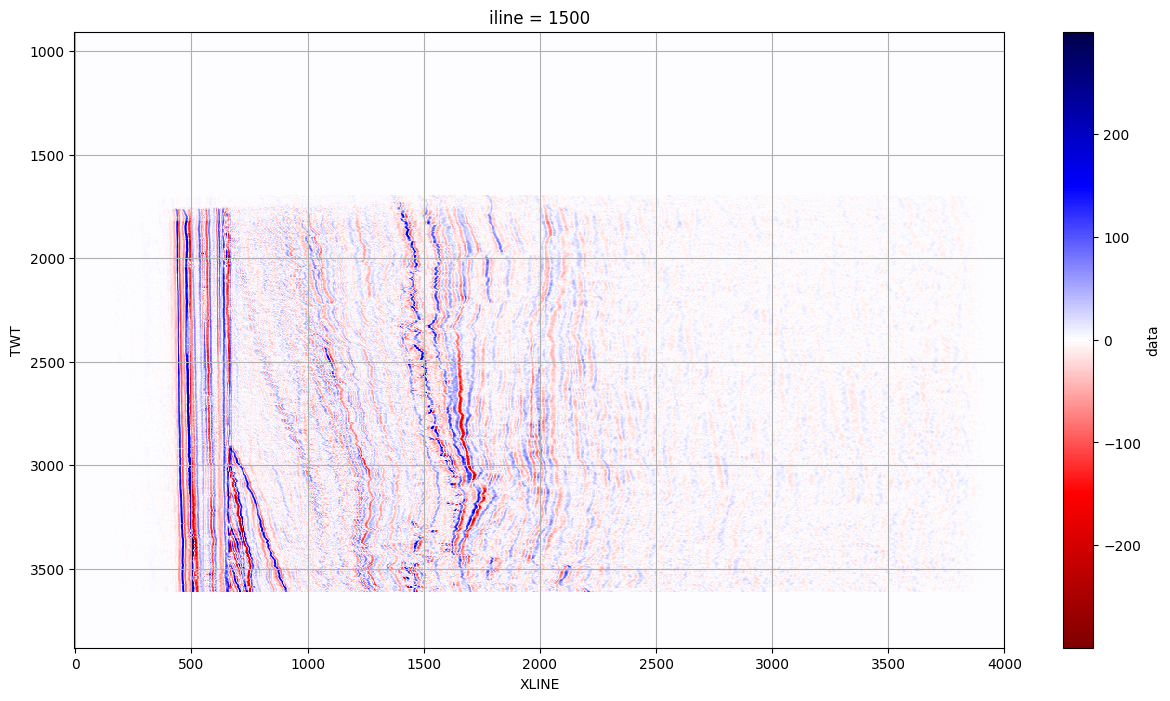

In [74]:
%matplotlib inline
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1500
V3D.data.transpose("iline", "xline", 'samples').sel(iline=iline_sel).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")
plt.show()

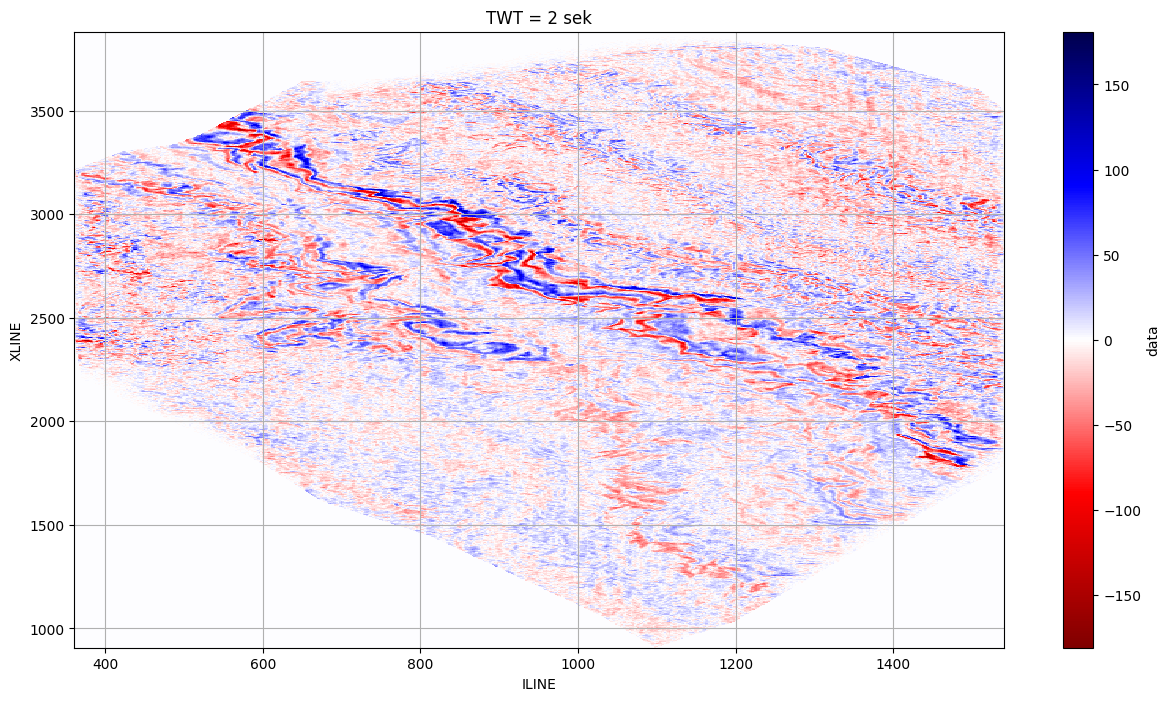

In [75]:
dt = 2

twt_array = V3D["samples"].data * dt

V3D = V3D.assign_coords(twt=("samples", twt_array))

V3D = V3D.swap_dims({"samples": "twt"})

twt_value = 1998
data_at_twt = V3D.data.sel(twt=twt_value, method="nearest")

fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
data_at_twt.plot(x="iline", y="xline", cmap="seismic_r")
plt.grid("grey")
plt.ylabel("XLINE")
plt.xlabel("ILINE")
plt.title(f"TWT = 2 sek")
plt.show()

### Wycięcie fragmentu z danych

In [76]:
iline_range = (500, 1400)
xline_range = (2000, 3000)
twt_range   = (1900, 2100)

iline_range = slice(500, 1400)
xline_range = slice(2000, 3000)
twt_range   = slice(1900, 2100)

V3D_subset = V3D.sel(
    iline=iline_range,
    xline=xline_range,
    twt=twt_range
)

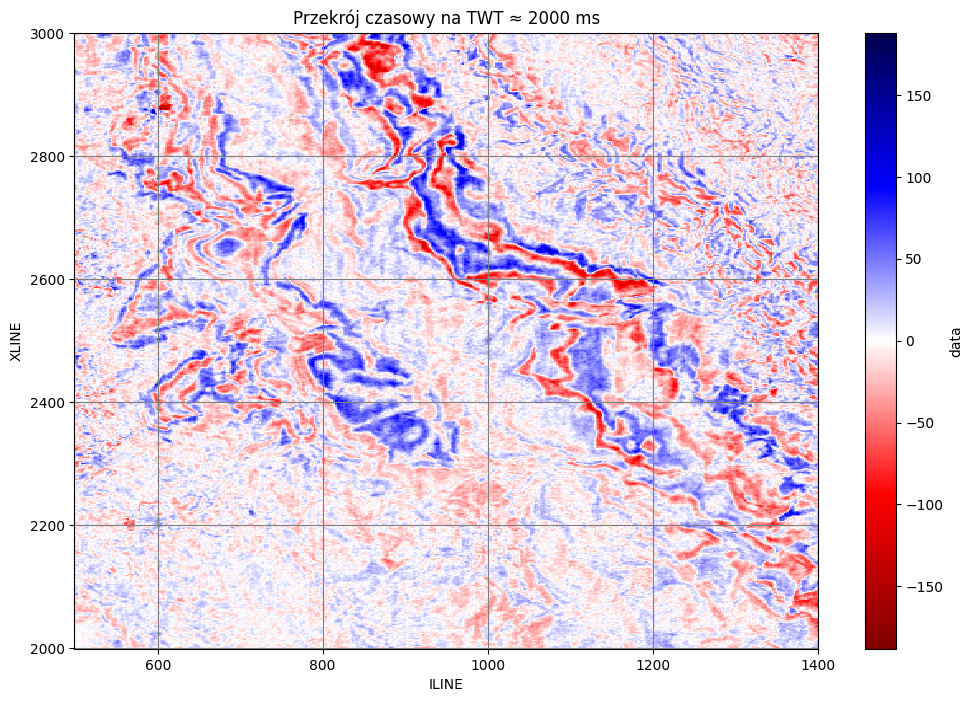

In [77]:
twt_value = 2000 
data_at_twt = V3D_subset["data"].sel(twt=twt_value, method="nearest")

fig, ax = plt.subplots(figsize=(12, 8))
data_at_twt.plot(
    x="iline",
    y="xline",
    cmap="seismic_r",
    ax=ax
)

plt.grid(color="grey")
plt.xlabel("ILINE")
plt.ylabel("XLINE")
plt.title(f"Przekrój czasowy na TWT ≈ {twt_value} ms")
plt.show()

### Konwersja do numpy array

In [78]:
numpy_array = V3D_subset["data"].values

print(type(numpy_array)) 
print(numpy_array.shape)

<class 'numpy.ndarray'>
(451, 501, 26)


### K-means (k=4)

In [79]:
slice_2d = V3D_subset["data"].sel(twt=2000, method="nearest").values

X = slice_2d.reshape(-1, 1)

k = 4
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

labels_kmeans = kmeans.labels_.reshape(slice_2d.shape)

### Fuzzy C-means (c=4)

In [80]:
data_fcm = X.T  

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_fcm,
    c=k,
    m=2, 
    error=0.005,
    maxiter=1000,
    init=None
)

labels_fcm = np.argmax(u, axis=0)
labels_fcm = labels_fcm.reshape(slice_2d.shape)

### Wizualizacja utworzonych klastrów

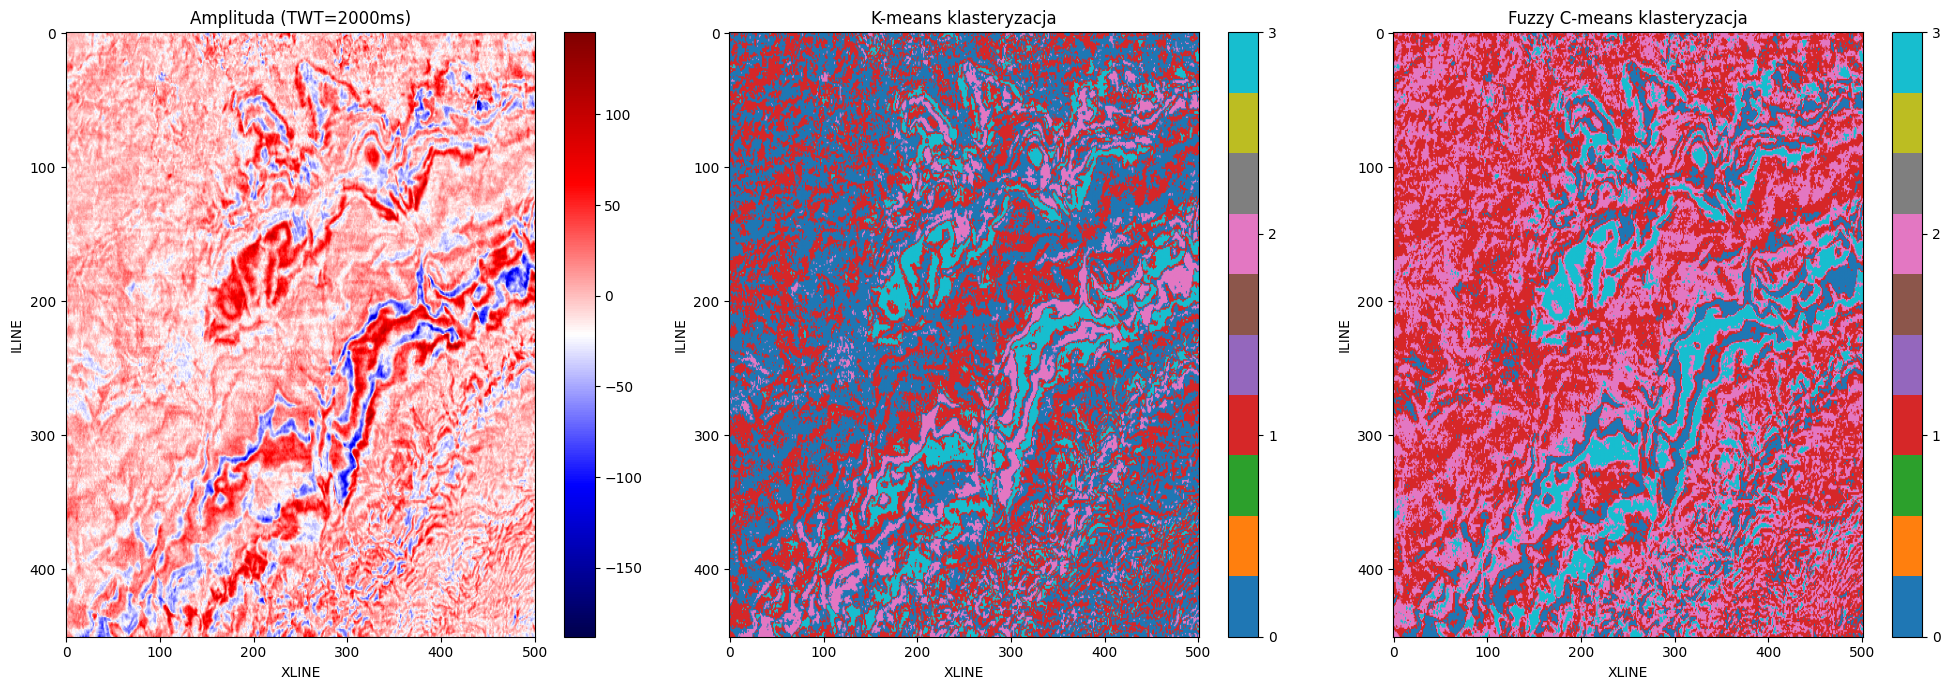

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

im0 = axs[0].imshow(slice_2d, cmap='seismic', aspect='auto')
axs[0].set_title("Amplituda (TWT=2000ms)")
plt.colorbar(im0, ax=axs[0])

# K-means
im1 = axs[1].imshow(labels_kmeans, cmap='tab10', aspect='auto')
axs[1].set_title("K-means klasteryzacja")
plt.colorbar(im1, ax=axs[1], ticks=range(k))

# FCM
im2 = axs[2].imshow(labels_fcm, cmap='tab10', aspect='auto')
axs[2].set_title("Fuzzy C-means klasteryzacja")
plt.colorbar(im2, ax=axs[2], ticks=range(k))

for ax in axs:
    ax.set_xlabel("XLINE")
    ax.set_ylabel("ILINE")

plt.tight_layout()
plt.show()

Lewy wykres — surowe dane amplitudy sejsmicznej dla wybranego czasu.

Środkowy wykres — wynik k-means: twardy podział na klastry.

Prawy wykres — wynik fuzzy c-means, gdzie każdy punkt przypisany jest do klastra, ale z miękkim przypisaniem 

| Cecha                        | k-means                                                 | fuzzy c-means (FCM)                                                                 |
| ---------------------------- | ------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| **Typ klasteryzacji**        | Twarda (hard clustering)                                | Miękka (soft clustering)                                                            |
| **Przynależność do klastra** | Punkt należy do dokładnie jednego klastra               | Punkt może mieć różne stopnie przynależności do wielu klastrów (wartości od 0 do 1) |
| **Wynik**                    | Etykieta klastra dla każdego punktu                     | Macierz przynależności (membership)                                                 |
| **Koszt obliczeniowy**       | Szybszy, prostszy                                       | Wolniejszy, bardziej złożony obliczeniowo                                           |
| **Zastosowanie**             | Gdy klastry są dobrze rozdzielone i chcemy prosty model | Gdy granice między klastrami są rozmyte, bardziej elastyczne podejście              |


Najbardziej znaczącą różnicą jest ostrość granic klastrów. K-means generuje wyraźne, często blokowe granice ze względu na swoje twarde przypisanie. Fuzzy C-means, z drugiej strony, ma tendencję do tworzenia płynniejszych przejść między klastrami, co odzwierciedla probabilistyczne przypisanie pikseli do wielu klastrów.

Mapy K-means mogą czasami wydawać się bardziej proste ze względu na ich wyraźne podziały, podczas gdy Fuzzy C-means może oferować bardziej zniuansowaną i geologicznie realistyczną reprezentację.

Fuzzy C-means technicznie dostarcza więcej informacji (stopnie przynależności dla każdego klastra) niż K-means (tylko przypisany klaster). Ta dodatkowa informacja może być wartościowa dla dalszej analizy.

### Inne parametry

In [82]:
# Dane 2D
slice_2d = V3D_subset["data"].sel(twt=2000, method="nearest").values

# Maksimum w oknie 5x5
max_window = generic_filter(slice_2d, np.max, size=5)
print(f"Max amplitude - min: {max_window.min():.3f}, max: {max_window.max():.3f}, mean: {max_window.mean():.3f}, std: {max_window.std():.3f}")

# Średnia w oknie 5x5
mean_window = uniform_filter(slice_2d, size=5)
print(f"Mean amplitude - min: {mean_window.min():.3f}, max: {mean_window.max():.3f}, mean: {mean_window.mean():.3f}, std: {mean_window.std():.3f}")

# Odchylenie standardowe w oknie 5x5
def std_filter(x):
    return np.std(x)
std_window = generic_filter(slice_2d, std_filter, size=5)
print(f"Std amplitude - min: {std_window.min():.3f}, max: {std_window.max():.3f}, mean: {std_window.mean():.3f}, std: {std_window.std():.3f}")

# Energia (sum of squares) w oknie 5x5
def energy_filter(x):
    return np.sum(x**2)
energy_window = generic_filter(slice_2d, energy_filter, size=5)
print(f"Energy - min: {energy_window.min():.3f}, max: {energy_window.max():.3f}, mean: {energy_window.mean():.3f}, std: {energy_window.std():.3f}")

# Gradient i średnia wartość gradientu w oknie 5x5
gy, gx = np.gradient(slice_2d)
gradient_magnitude = np.sqrt(gx**2 + gy**2)
gradient_mean = uniform_filter(gradient_magnitude, size=5)
print(f"Gradient magnitude - min: {gradient_mean.min():.3f}, max: {gradient_mean.max():.3f}, mean: {gradient_mean.mean():.3f}, std: {gradient_mean.std():.3f}")


Max amplitude - min: -92.851, max: 145.229, mean: 26.357, std: 23.078
Mean amplitude - min: -125.516, max: 101.898, mean: -0.022, std: 20.236
Std amplitude - min: 1.166, max: 78.685, mean: 14.219, std: 7.963
Energy - min: 56.682, max: 413701.562, mean: 16877.105, std: 24541.236
Gradient magnitude - min: 1.664, max: 52.267, mean: 11.783, std: 5.652
